compretition [https://www.kaggle.com/c/store-sales-time-series-forecasting/overview](https://www.kaggle.com/c/store-sales-time-series-forecasting/overview)

In [1]:
# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from utils import plot_periodogram, seasonal_plot



comp_dir = Path('./input')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)['sales']

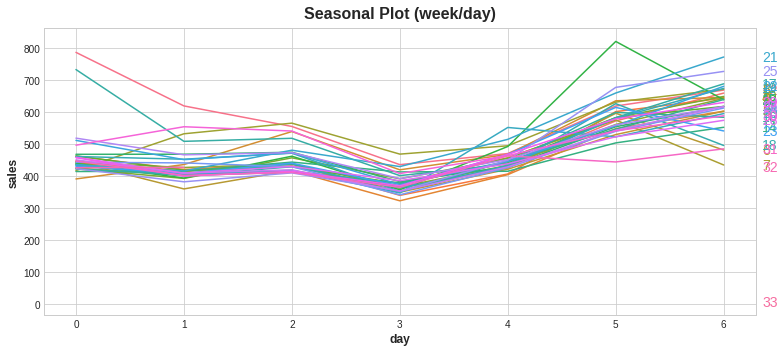

In [2]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

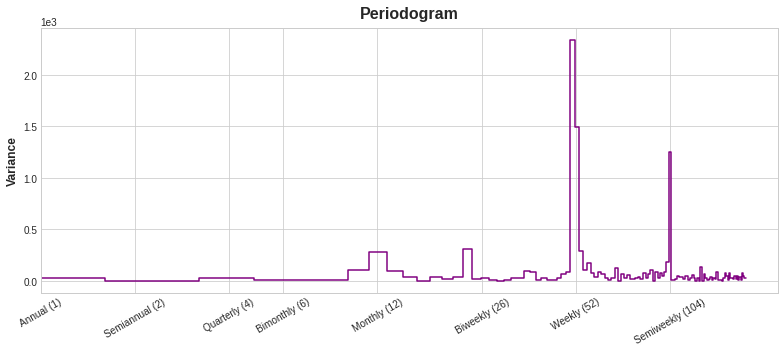

In [3]:
plot_periodogram(average_sales);

In [4]:
y = average_sales.copy()
# YOUR CODE HERE
fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    # YOUR CODE HERE
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample() 


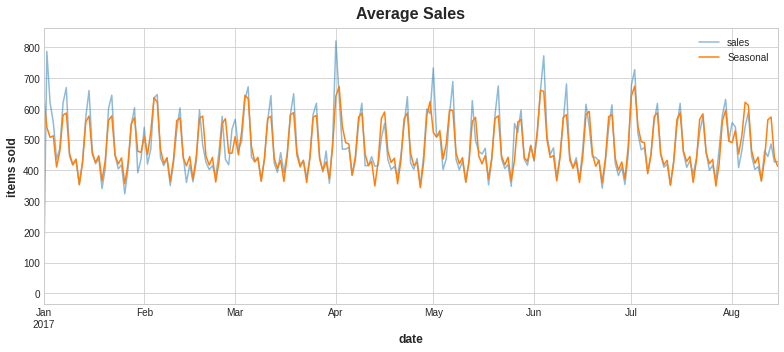

In [5]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

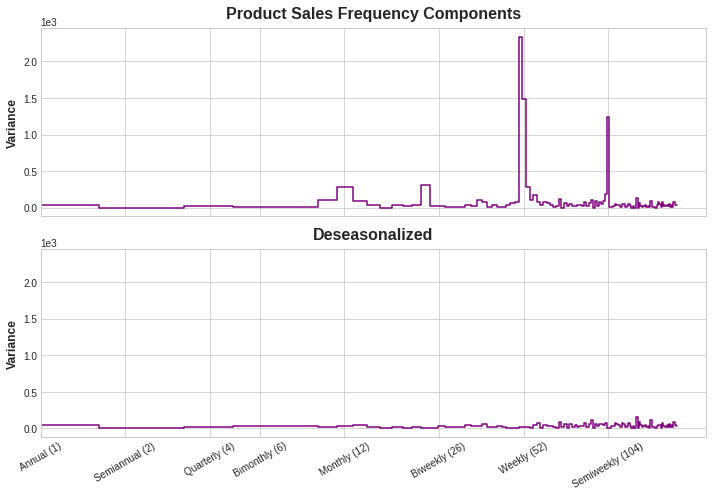

In [6]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

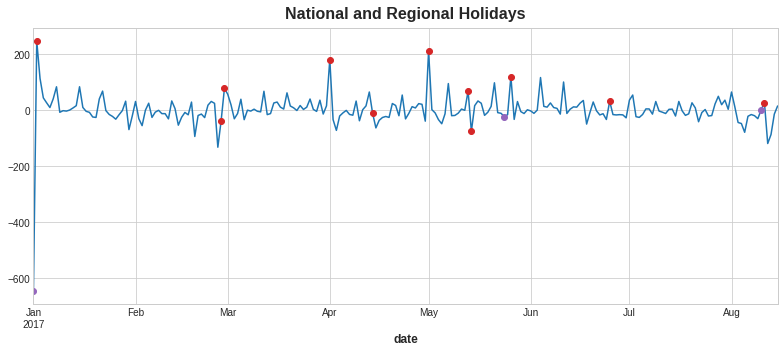

In [7]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description', 'transferred']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)
holidays[holidays['transferred']==False]
ax = y_deseason.plot()
transferred_holidays = holidays[holidays['transferred']==True]
not_transferred_holidays = holidays[holidays['transferred']==False]
plt.plot_date(transferred_holidays.index, y_deseason[transferred_holidays.index], color='C4')
plt.plot_date(not_transferred_holidays.index, y_deseason[not_transferred_holidays.index], color='C3')

ax.set_title('National and Regional Holidays');

In [8]:
X_holidays = pd.get_dummies(holidays)

In [9]:
store_ids = store_sales.index.get_level_values('store_nbr').unique().sort_values()
families = store_sales.index.get_level_values('family').unique().sort_values()

## CONTINUE

In [10]:
def get_best_freq(ts, detrend='linear', ax=None):
    ''' return 's' : second
        'min' : minute
        'H' : hour
        'D' : day
        'SM' : semiweekly
        'w' : week
        '2w' : biweekly
        'm' : month
    '''
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    na, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    options = {
        1: 'y', 
        2: '6m', 
        4: '3m', 
        6: '2m', 
        12: 'm', 
        26: '2w', 
        52: 'w', 
        # 104: 'SM'
    }  
    max_value_index = np.where(np.max(spectrum) == spectrum)
    early_max_value = min(options.keys(), key=lambda x:abs(x-max_value_index[0][0]))
    values = {spectrum[number]: frequency for number, frequency in options.items()}
    return options[early_max_value]

def get_model(store_nbr, family):
    sales = store_sales.loc[store_nbr,:].loc[family,:].sort_index().loc['2017']
    # ax = plot_periodogram(sales.squeeze().loc['2017']);
    #####################
    # meta parameters
    #####################
    freq = get_best_freq(sales['sales'].squeeze())
    # print(freq)
    #####################
    # train
    #####################
    y = sales['sales'].to_frame()
    # fourier = CalendarFourier(freq=freq, order=4) empeoro el codigo
    fourier = CalendarFourier(freq="M", order=4)
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True,
    )
    X = dp.in_sample()
    X['NewYear'] = (X.index.dayofyear == 1)
    X['onpromotion'] = sales['onpromotion'] 
    X = X.join(X_holidays, on='date').fillna(0.0) # mejoro muy poco

    #####################
    # train
    #####################
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    # y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)# options.keys()
    return model, dp, y
    # ax = y.plot()
    # ax = y_pred.plot(ax=ax)
    # ax.set_title(f'{family} Sales at Store {store_nbr} frequency {freq}');


In [11]:
df_store_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_store_test['date'] = df_store_test.date.dt.to_period('D')
df_store_test = df_store_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [12]:

store_models = {}
y_submit = pd.DataFrame(columns=['id', 'sales'])
for store_nbr in store_ids:
    for family in families:
        # family = FAMILY
        model, dp, y = get_model(store_nbr, family)
        # # Create features for test set
        X_test = dp.out_of_sample(steps=16)
        X_test.index.name = 'date'
        df_test = df_store_test.loc[store_nbr, :].loc[family,:].sort_index()
        X_test['NewYear'] = (X_test.index.dayofyear == 1)
        X_test['onpromotion'] = df_test['onpromotion'] 

        X_test = X_test.join(X_holidays, on='date').fillna(0.0) # mejoro muy poco

        result = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
        result = result.join(df_test.id)
        # print(result)
        y_submit = pd.concat([y_submit, result])

y_submit.sort_values('id', inplace=True)
# print(y_submit)

In [13]:
y_submit.loc[y_submit['sales'] < 0, 'sales'] = 0

In [14]:
y_submit.to_csv('submission.csv', index=False)